In [50]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
from geopy.distance import geodesic
import joblib

In [51]:
df = pd.read_csv('dataset.csv')
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,01-01-2019 00:00,2.700000e+15,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",09-03-1988,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,01-01-2019 00:00,6.300000e+11,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,21-06-1978,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,01-01-2019 00:00,3.890000e+13,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,19-01-1962,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,01-01-2019 00:01,3.530000e+15,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,12-01-1967,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,01-01-2019 00:03,3.760000e+14,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,28-03-1986,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [52]:
df['trans_date_trans_time'] = pd.to_datetime (df['trans_date_trans_time'])
df['hour'] = df ['trans_date_trans_time'].dt.hour
df['day'] = df['trans_date_trans_time'].dt.day
df['month'] = df['trans_date_trans_time'].dt.month

In [53]:
drop_columns = ['Unnamed: 0', 'trans_date_trans_time', 'first', 'last', 'street', 'city', 'state', 'zip', 'dob', 'job', 'trans_num']
df = df.drop(columns=drop_columns)

In [54]:
df.head()

,cc_num,merchant,category,amt,gender,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,hour,day,month
0,2.700000e+15,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315,0,0,1,1
1,6.300000e+11,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,0,0,1,1
2,3.890000e+13,fraud_Lind-Buckridge,entertainment,220.11,M,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481,0,0,1,1
3,3.530000e+15,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071,0,0,1,1
4,3.760000e+14,fraud_Keeling-Crist,misc_pos,41.96,M,38.4207,-79.4629,99,1325376186,38.674999,-78.632459,0,0,1,1


In [55]:
cat_col = ['merchant', 'category', 'gender']
encoders = {}
for col in cat_col:
    encoders[col] =LabelEncoder()
    df[col]=encoders[col].fit_transform(df[col])

In [56]:
def haversine (lat1, lon1, lat2, lon2):
    return np.array([geodesic((a,b), (c,d)).km for a,b,c,d in zip(lat1, lon1, lat2, lon2)])

df['distance'] = haversine (df['lat'], df ['long'], df['merch_lat'], df ['merch_long'])

In [57]:
df.head()

,cc_num,merchant,category,amt,gender,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,hour,day,month,distance
0,2.700000e+15,514,8,4.97,0,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315,0,0,1,1,78.773821
1,6.300000e+11,241,4,107.23,0,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,0,0,1,1,30.216618
2,3.890000e+13,390,0,220.11,1,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481,0,0,1,1,108.102912
3,3.530000e+15,360,2,45.00,1,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071,0,0,1,1,95.685115
4,3.760000e+14,297,9,41.96,1,38.4207,-79.4629,99,1325376186,38.674999,-78.632459,0,0,1,1,77.702395


In [58]:
features = ['merchant', 'category', 'amt', 'cc_num', 'hour', 'day', 'month', 'gender', 'distance']
x = df [features]
y=df['is_fraud']

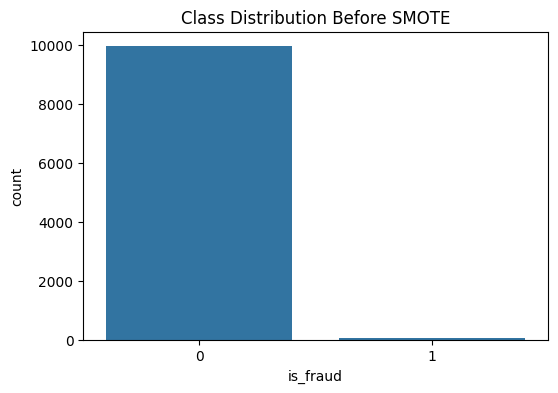

In [59]:
plt.figure(figsize=(6,4))
sns.countplot(x='is_fraud', data=df)
plt.title("Class Distribution Before SMOTE")
plt.show()

In [60]:
smote = SMOTE(random_state=42)
x_resample, y_resample = smote.fit_resample(x,y)

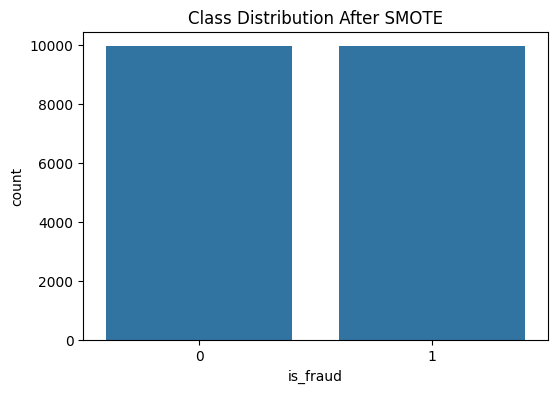

In [61]:
plt.figure(figsize=(6,4))
sns.countplot(x=y_resample)
plt.title("Class Distribution After SMOTE")
plt.show()

In [62]:
x_train, x_test, y_train, y_test = train_test_split (x_resample, y_resample, test_size=0.2, random_state=42)

In [43]:
lgb_model = lgb.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    metrics='auc',
    is_unbalance = True,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=1,
    n_estimators=200
)
lgb_model.fit(x_train,y_train)

[LightGBM] [Info] Number of positive: 7997, number of negative: 7926
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1066
[LightGBM] [Info] Number of data points in the train set: 15923, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502229 -> initscore=0.008918
[LightGBM] [Info] Start training from score 0.008918
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,1
,learning_rate,0.05
,n_estimators,200
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [63]:
y_pred = lgb_model.predict(x_test)

In [64]:
print("Classification_Report:\n", classification_report(y_test,y_pred))
print("Roc AUC Score: ",roc_auc_score(y_test, y_pred)) 

Classification_Report:
               precision    recall  f1-score   support

           0       0.84      0.97      0.90      2026
           1       0.96      0.81      0.88      1956

    accuracy                           0.89      3982
   macro avg       0.90      0.89      0.89      3982
weighted avg       0.90      0.89      0.89      3982

Roc AUC Score:  0.8908585121437671


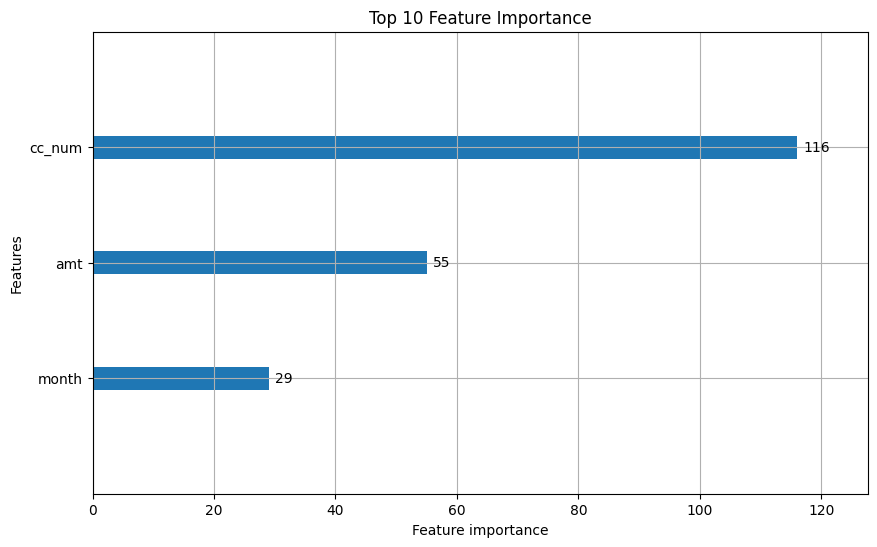

In [65]:
lgb.plot_importance(lgb_model, max_num_features=10, importance_type='split',figsize=(10,6))
plt.title("Top 10 Feature Importance")
plt.show()

In [66]:
fpr, tpr, thresholds = roc_curve(y_test,lgb_model.predict_proba(x_test)[:,1])
roc_auc = auc(fpr, tpr)

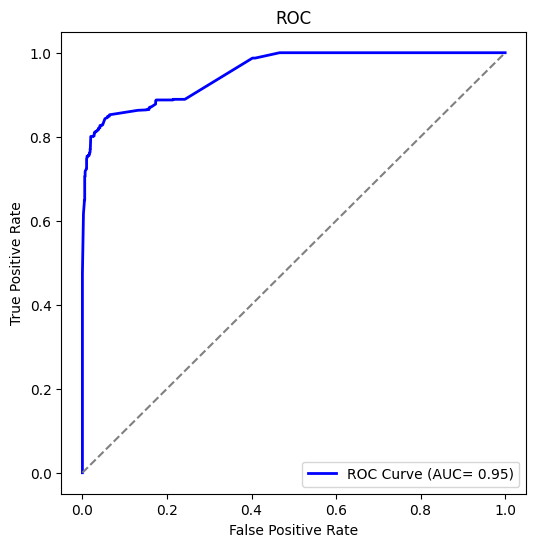

In [67]:
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC= {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [68]:
joblib.dump(lgb_model, 'fraud_detection_model.jb')  
joblib.dump(encoders, 'label_encoder.jb')

['label_encoder.jb']

In [69]:
df[df['is_fraud']==1].head()

,cc_num,merchant,category,amt,gender,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,hour,day,month,distance
2449,4.610000e+12,543,4,281.06,1,35.9946,-81.7266,885,1325466397,36.430124,-81.179483,1,1,1,2,68.962726
2472,3.400000e+14,285,2,11.52,0,29.4400,-98.4590,1595797,1325468849,29.819364,-99.142791,1,1,1,2,78.443229
2523,3.400000e+14,196,4,276.31,0,29.4400,-98.4590,1595797,1325473523,29.273085,-98.836360,1,3,1,2,41.048425
2546,4.610000e+12,162,2,7.03,1,35.9946,-81.7266,885,1325475483,35.909292,-82.091010,1,3,1,2,34.211963
2553,3.400000e+14,328,4,275.73,0,29.4400,-98.4590,1595797,1325476547,29.786426,-98.683410,1,3,1,2,44.124854
